# Uber: Insights from City Supply and Demand Data

**Leng Yang**

**Last Updated: 1/28/25**

## Assignment

Project Source: https://platform.stratascratch.com/data-projects/insights-city-supply-and-demand-data

Using the provided dataset, answer the following questions:

1. Which date had the most completed trips during the two week period?
2. What was the highest number of completed trips within a 24 hour period?
3. Which hour of the day had the most requests during the two week period?
4. What percentages of all zeroes during the two week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)? Tip: The local time value is the start of the hour (e.g. 15 is the hour from 3:00pm - 4:00pm)
5. What is the weighted average ratio of completed trips per driver during the two week period? Tip: "Weighted average" means your answer should account for the total trip volume in each hour to determine the most accurate number in whole period.
6. In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests? A new shift starts in every 8 hours. Assume that a driver will work same shift each day.
7. True or False: Driver supply always increases when demand increases during the two week period. Tip: Visualize the data to confirm your answer if needed.
8. In which 72 hour period is the ratio of Zeroes to Eyeballs the highest?
9. If you could add 5 drivers to any single hour of every day during the two week period, which hour should you add them to? Hint: Consider both rider eyeballs and driver supply when choosing
10. True or False: There is exactly two weeks of data in this analysis
11. Looking at the data from all two weeks, which time might make the most sense to consider a true "end day" instead of midnight? (i.e when are supply and demand at both their natural minimums) Tip: Visualize the data to confirm your answer if needed.

## Data Description

To answer the question, use the dataset from the file `dataset_1.csv`.
* Date: date of transaction
* Time (Local): 24-hr time format, 1-hour time blocks
* Eyeballs: # of users who opened the app
* Zeroes: # of users who did not see any available cars/drivers
* Completed Trips: # of completed trips based on the Requests
* Requests: # of requests
* Unique Drivers: # of unique drivers logged in

<BR><BR>

In [6]:
#Load in necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#Load in dataset into Pandas and fill in dates
df = pd.read_csv('./datasets/dataset_1.csv').ffill()
#Rename columns
df.columns = df.columns.str.lower().str.replace('(','').str.replace(')','').str.strip().str.replace(' ','_')
#Format date column
df.date = pd.to_datetime(df.date, format='%d-%b-%y')

In [8]:
#Look at info of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             336 non-null    datetime64[ns]
 1   time_local       336 non-null    int64         
 2   eyeballs         336 non-null    int64         
 3   zeroes           336 non-null    int64         
 4   completed_trips  336 non-null    int64         
 5   requests         336 non-null    int64         
 6   unique_drivers   336 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 18.5 KB


In [9]:
#Preview first 5 records
df.head()

,date,time_local,eyeballs,zeroes,completed_trips,requests,unique_drivers
0,2012-09-10,7,5,0,2,2,9
1,2012-09-10,8,6,0,2,2,14
2,2012-09-10,9,8,3,0,0,14
3,2012-09-10,10,9,2,0,1,14
4,2012-09-10,11,11,1,4,4,11


### 1. Which date had the most completed trips during the two week period?

9/22/2012 had the most comnpleted trips.

In [12]:
df.groupby('date')['completed_trips'].sum().sort_values(ascending=False)

date
2012-09-22    248
2012-09-15    199
2012-09-21    190
2012-09-23    111
2012-09-14    108
2012-09-16     93
2012-09-12     91
2012-09-20     70
2012-09-17     57
2012-09-13     45
2012-09-18     42
2012-09-19     41
2012-09-11     40
2012-09-10     26
2012-09-24      4
Name: completed_trips, dtype: int64

<BR>

### 2. What was the highest number of completed trips within a 24 hour period?

The highest was 278 completed trips over a 24-hr time period.

In [16]:
#Compute sum of completed trips over a rolling 24-hr window
df.completed_trips.rolling(24).sum().sort_values(ascending=False)

297    278.0
296    274.0
300    261.0
312    260.0
298    260.0
       ...  
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
Name: completed_trips, Length: 336, dtype: float64

<BR>

### 3. Which hour of the day had the most requests during the two week period?

11 PM had the most requests.

In [20]:
df.groupby('time_local')['requests'].sum().sort_values(ascending=False)

time_local
23    184
22    174
19    156
0     142
18    119
21    112
20    107
2     100
17     98
1      96
16     82
14     71
15     71
13     55
12     53
11     47
3      35
8      29
10     28
6      28
9      26
7      22
5      14
4       9
Name: requests, dtype: int64

<BR>

### 4. What percentages of all zeroes during the two week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)?
Tip: The local time value is the start of the hour (e.g. 15 is the hour from 3:00pm - 4:00pm)

About 44.86% of zeroes occur during the weekend.

In [24]:
#Get day of week from date
df['day_of_week'] = df.date.dt.day_name()

In [25]:
#Select all zeroes during a weekend timeframe and calculate the sum during this time period
z_wknd = df.loc[(df.day_of_week == 'Saturday') | ((df.day_of_week == 'Friday') & (df.time_local >= 17)) | ((df.day_of_week == 'Sunday') & (df.time_local <= 2)), 'zeroes'].sum()
#Calculate sum of zeroes over the entire period
z_all = df.zeroes.sum()
#Calculate the requested percentage
z_wknd / z_all * 100

44.856543037088876

<BR>

### 5. What is the weighted average ratio of completed trips per driver during the two week period?
Tip: "Weighted average" means your answer should account for the total trip volume in each hour to determine the most accurate number in whole period.

In [28]:
#Calculate ratio
df['completed_trips_per_driver_ratio'] = df.completed_trips / df.unique_drivers

In [29]:
#Drop rows without unique drivers to prevent miscalculations (nan and inf)
df_ratio = df[df.unique_drivers > 0]
#Calculate weighted average using number of completed trips every hour as weights
np.average(df_ratio.completed_trips_per_driver_ratio, weights=df_ratio.completed_trips)

0.8282775715092395

<BR>

### 6. In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests?
A new shift starts in every 8 hours. Assume that a driver will work same shift each day.

The busiest 8-hr schedule, based on the number of requests, began on 9/21 at 5 PM and ended on 9/22 at 1 AM.

In [33]:
#Create column containing rolling sum over 8-hr periods based on the number of requests, shifting values to the beginning of the shift
df['eight_hr_shift'] = df.requests.rolling(8, min_periods=1).sum().shift(-7)

In [34]:
#Determine the index containing the end of the window with the highest requests
df.eight_hr_shift.idxmax()

274

In [35]:
#Look at 8-hr window
df.loc[274:281]

,date,time_local,eyeballs,zeroes,completed_trips,requests,unique_drivers,day_of_week,completed_trips_per_driver_ratio,eight_hr_shift
274,2012-09-21,17,68,25,26,26,20,Friday,1.300000,207.0
275,2012-09-21,18,62,6,15,22,26,Friday,0.576923,205.0
276,2012-09-21,19,47,3,16,19,30,Friday,0.533333,201.0
277,2012-09-21,20,63,8,14,21,28,Friday,0.500000,185.0
278,2012-09-21,21,59,8,12,17,27,Friday,0.444444,167.0
279,2012-09-21,22,73,4,23,29,26,Friday,0.884615,152.0
280,2012-09-21,23,94,30,36,46,26,Friday,1.384615,124.0
281,2012-09-22,0,62,4,19,27,27,Saturday,0.703704,78.0


<BR>

### 7. True or False: Driver supply always increases when demand increases during the two week period.
Tip: Visualize the data to confirm your answer if needed.

The number of drivers typically increases as the number of requests increases. Hence, it is true that supply increases as demand increases.

In [39]:
#Combine date and time columns into a timestamp column
df['timestamp'] = df.date + pd.to_timedelta(df.time_local, unit='h')

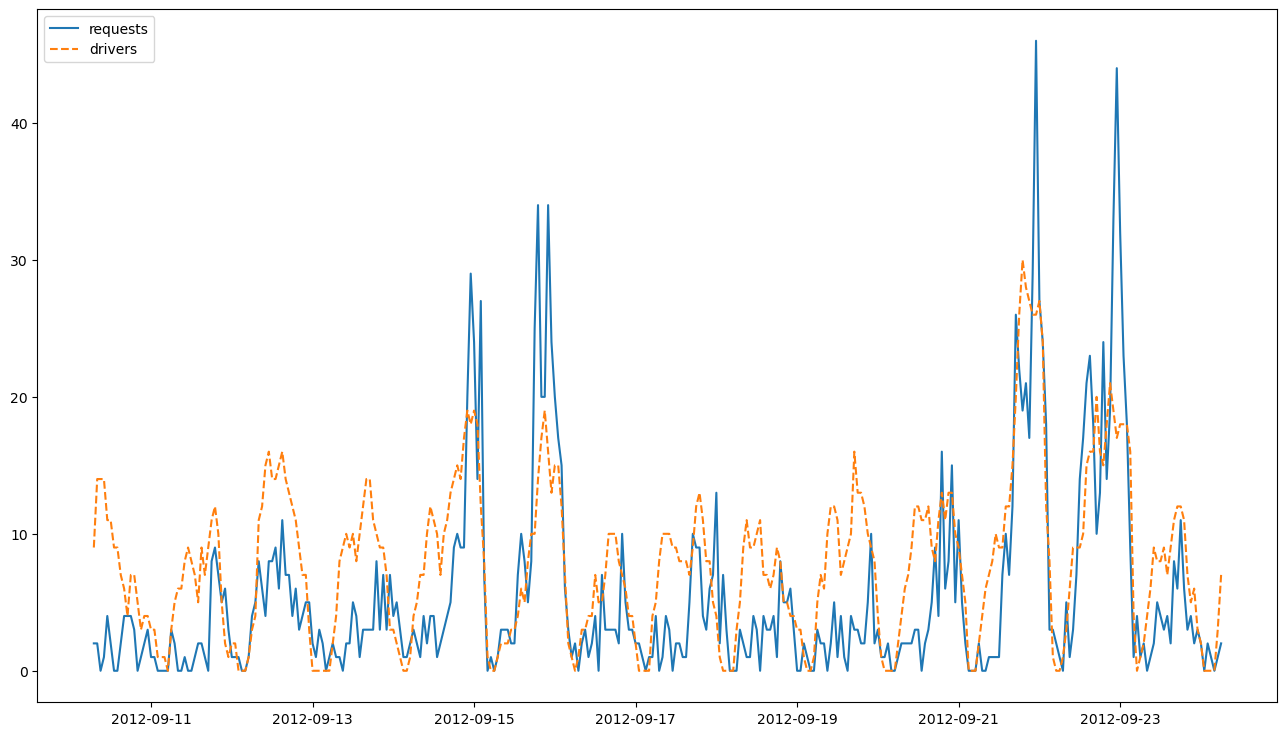

In [40]:
plt.figure(figsize=[16,9])
plt.plot(df.timestamp, df.requests, label='requests')
plt.plot(df.timestamp, df.unique_drivers, '--', label='drivers')
plt.legend(loc='upper left');

<BR>

### 8. In which 72 hour period is the ratio of Zeroes to Eyeballs the highest?

The period from 9/15 5 AM to 9/18 5 AM had the highest ratio at 0.29.

In [44]:
#drop unnecessary columns, set timestamp as index, calculate rolling window for 3 days/72 hours, and shift results up 71 rows to get a forward rolling window calculation
df_three_day = df.drop(columns=['date','day_of_week']).set_index("timestamp").rolling(window=72, min_periods=1).sum().shift(-71).reset_index().dropna()

In [45]:
df_three_day['zeroes_to_eyeballs_ratio'] = df_three_day.zeroes / df_three_day.eyeballs
df_three_day.loc[df_three_day.zeroes_to_eyeballs_ratio.idxmax()]

timestamp                           2012-09-15 05:00:00
time_local                                        828.0
eyeballs                                         1495.0
zeroes                                            438.0
completed_trips                                   292.0
requests                                          431.0
unique_drivers                                    454.0
completed_trips_per_driver_ratio              37.088176
eight_hr_shift                                   3439.0
zeroes_to_eyeballs_ratio                       0.292977
Name: 118, dtype: object

<BR>

### 9. If you could add 5 drivers to any single hour of every day during the two week period, which hour should you add them to?
Hint: Consider both rider eyeballs and driver supply when choosing

Adding drivers where there is a high ratio of users to the number of currently active drivers makes the most sense. The highest ratio occurs at 11 PM, where more drivers should be added.

In [49]:
#Aggregate results by hour and calculate ratio
df_hr = df.groupby('time_local')[['eyeballs','unique_drivers']].sum()
df_hr['eyeball_driver_ratio'] = df_hr.eyeballs / df_hr.unique_drivers

In [50]:
df_hr[df_hr.index == df_hr.eyeball_driver_ratio.idxmax()]

,eyeballs,unique_drivers,eyeball_driver_ratio
time_local,,,
23,488,119,4.10084


<BR>

### 10. True or False: There is exactly two weeks of data in this analysis

The time for the data began on 9/10 at 7 AM and ends on 9/24 at 6 AM (which indicates a 6 AM - 7 AM timeblock). This suggests a complete two weeks of data.

In [54]:
df.head(1)

,date,time_local,eyeballs,zeroes,completed_trips,requests,unique_drivers,day_of_week,completed_trips_per_driver_ratio,eight_hr_shift,timestamp
0,2012-09-10,7,5,0,2,2,9,Monday,0.222222,11.0,2012-09-10 07:00:00


In [55]:
df.tail(1)

,date,time_local,eyeballs,zeroes,completed_trips,requests,unique_drivers,day_of_week,completed_trips_per_driver_ratio,eight_hr_shift,timestamp
335,2012-09-24,6,9,1,2,2,7,Monday,0.285714,NaN,2012-09-24 06:00:00


<BR>

### 11. Looking at the data from all two weeks, which time might make the most sense to consider a true "end day" instead of midnight? (i.e when are supply and demand at both their natural minimums)
Tip: Visualize the data to confirm your answer if needed.

By the looks of the table and visualization, the true "end day" would be at 4 AM, where both the number of requests and drivers are that their lowest.

In [59]:
#Aggregate number of requests and drivers by the hour of the day
df_hr_sd = df.groupby('time_local')[['requests','unique_drivers']].sum()

In [60]:
#Table of aggregated values
df_hr_sd

,requests,unique_drivers
time_local,,
0,142,111
1,96,94
2,100,62
3,35,40
4,9,9
5,14,11
6,28,37
7,22,60
8,29,95


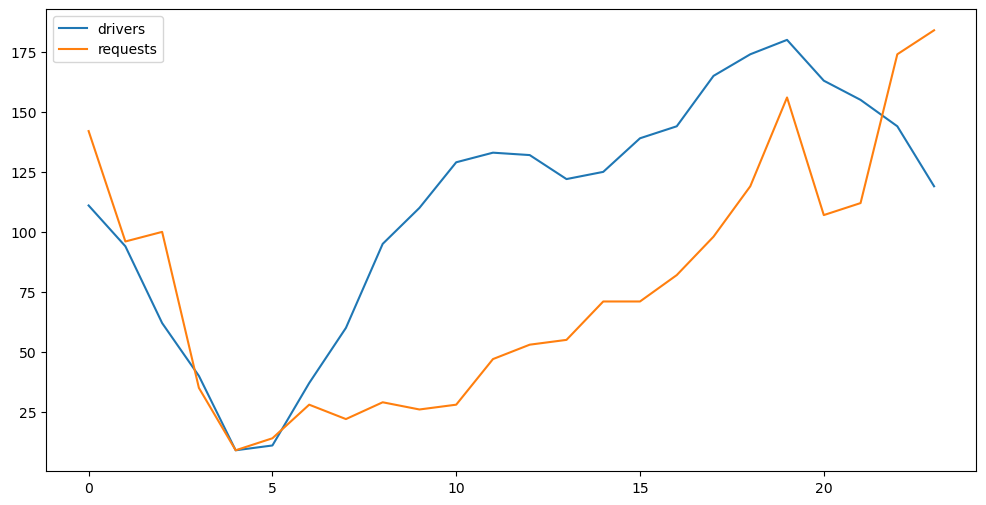

In [61]:
#Visual plot of supply and demand by the hour of the day
plt.figure(figsize=[12,6])
plt.plot(df_hr_sd.index, df_hr_sd.unique_drivers, label='drivers')
plt.plot(df_hr_sd.index, df_hr_sd.requests, label='requests')
plt.legend(loc='upper left');

<BR>